<a href="https://colab.research.google.com/github/MiHarsh/CodaLab-SharedTask/blob/main/TSNEplotsCodaLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

# Importing matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import sys
import re
!pip install emoji --quiet
import emoji
!pip install contractions --quiet
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import unicodedata

     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 245kB 5.5MB/s 
     |████████████████████████████████| 317kB 14.8MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))

    # We create a scatter plot.
    f = plt.figure(figsize=(64, 64))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [3]:
train_datapath="https://raw.githubusercontent.com/MiHarsh/MiHarsh/master/Constraint_English_Train%20-%20Sheet1.csv"
val_datapath  ="https://raw.githubusercontent.com/MiHarsh/MiHarsh/master/Constraint_English_Val%20-%20Sheet1.csv"
test_datapath ="https://raw.githubusercontent.com/MiHarsh/Public_stuffs/master/Constraint_English_Test%20-%20Sheet1.csv"
train         = pd.read_csv(train_datapath)[['tweet','label']]
train['label']= 0
valid         = pd.read_csv(val_datapath)[['tweet','label']]
valid['label']= 1
test          = pd.read_csv(test_datapath)[['tweet']]
test['label'] = 2
total         = pd.concat([train,valid,test]).reset_index(drop=True)
total

# ==== Train:0
# ==== Valid:1
# ==== Test :2

tweet  label
0      The CDC currently reports 99031 deaths. In gen...      0
1      States reported 1121 deaths a small rise from ...      0
2      Politically Correct Woman (Almost) Uses Pandem...      0
3      #IndiaFightsCorona: We have 1524 #COVID testin...      0
4      Populous states can generate large case counts...      0
...                                                  ...    ...
10695  #CoronaVirusUpdates: State-wise details of Tot...      2
10696  Tonight 12(midnight) onwards Disaster Manageme...      2
10697  296 new cases of #COVID19Nigeria; Plateau-85 E...      2
10698  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...      2
10699  More than half of pregnant women recently admi...      2

[10700 rows x 2 columns]

In [4]:
def cleaning(text):
  text= text.lower()
  text= emoji.demojize(text)
  text=contractions.fix(text)
  text=text.strip()
  text=text.replace('[^\w\s]','')
  text=re.sub(r'http\S+', '', text)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub(' ' , text)
  text = BAD_SYMBOLS_RE.sub(' ',text)
  
  return text

clean=total['tweet'].apply(cleaning)
STOPWORDS = set(stopwords.words('english'))

ff=[]
for i in clean:
  text=unicodedata.normalize('NFKD', i).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  ff.append(text)
dd=pd.DataFrame(ff,columns={'tweet'})
dataset = pd.concat([dd,total['label']],axis=1).reset_index(drop=True)
dataset

tweet  label
0      the cdc currently reports 99031 deaths  in gen...      0
1      states reported 1121 deaths a small rise from ...      0
2      politically correct woman  almost  uses pandem...      0
3       indiafightscorona  we have 1524  covid testin...      0
4      populous states can generate large case counts...      0
...                                                  ...    ...
10695   coronavirusupdates  state wise details of tot...      2
10696  tonight 12 midnight  onwards disaster manageme...      2
10697  296 new cases of  covid19nigeria  plateau 85 e...      2
10698  rt  cdcemergency   dyk   cdcgov s one stop sho...      2
10699  more than half of pregnant women recently admi...      2

[10700 rows x 2 columns]

**Making Features using TFidfVectorizer**

**First Visualisation of Train and Validation Set**

In [5]:
tfidf = TfidfVectorizer()
df    = dataset[dataset.label!=2].reset_index(drop=True)
X     = tfidf.fit_transform(df.tweet)
y     = df.label

['Train', 'Validation']


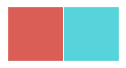

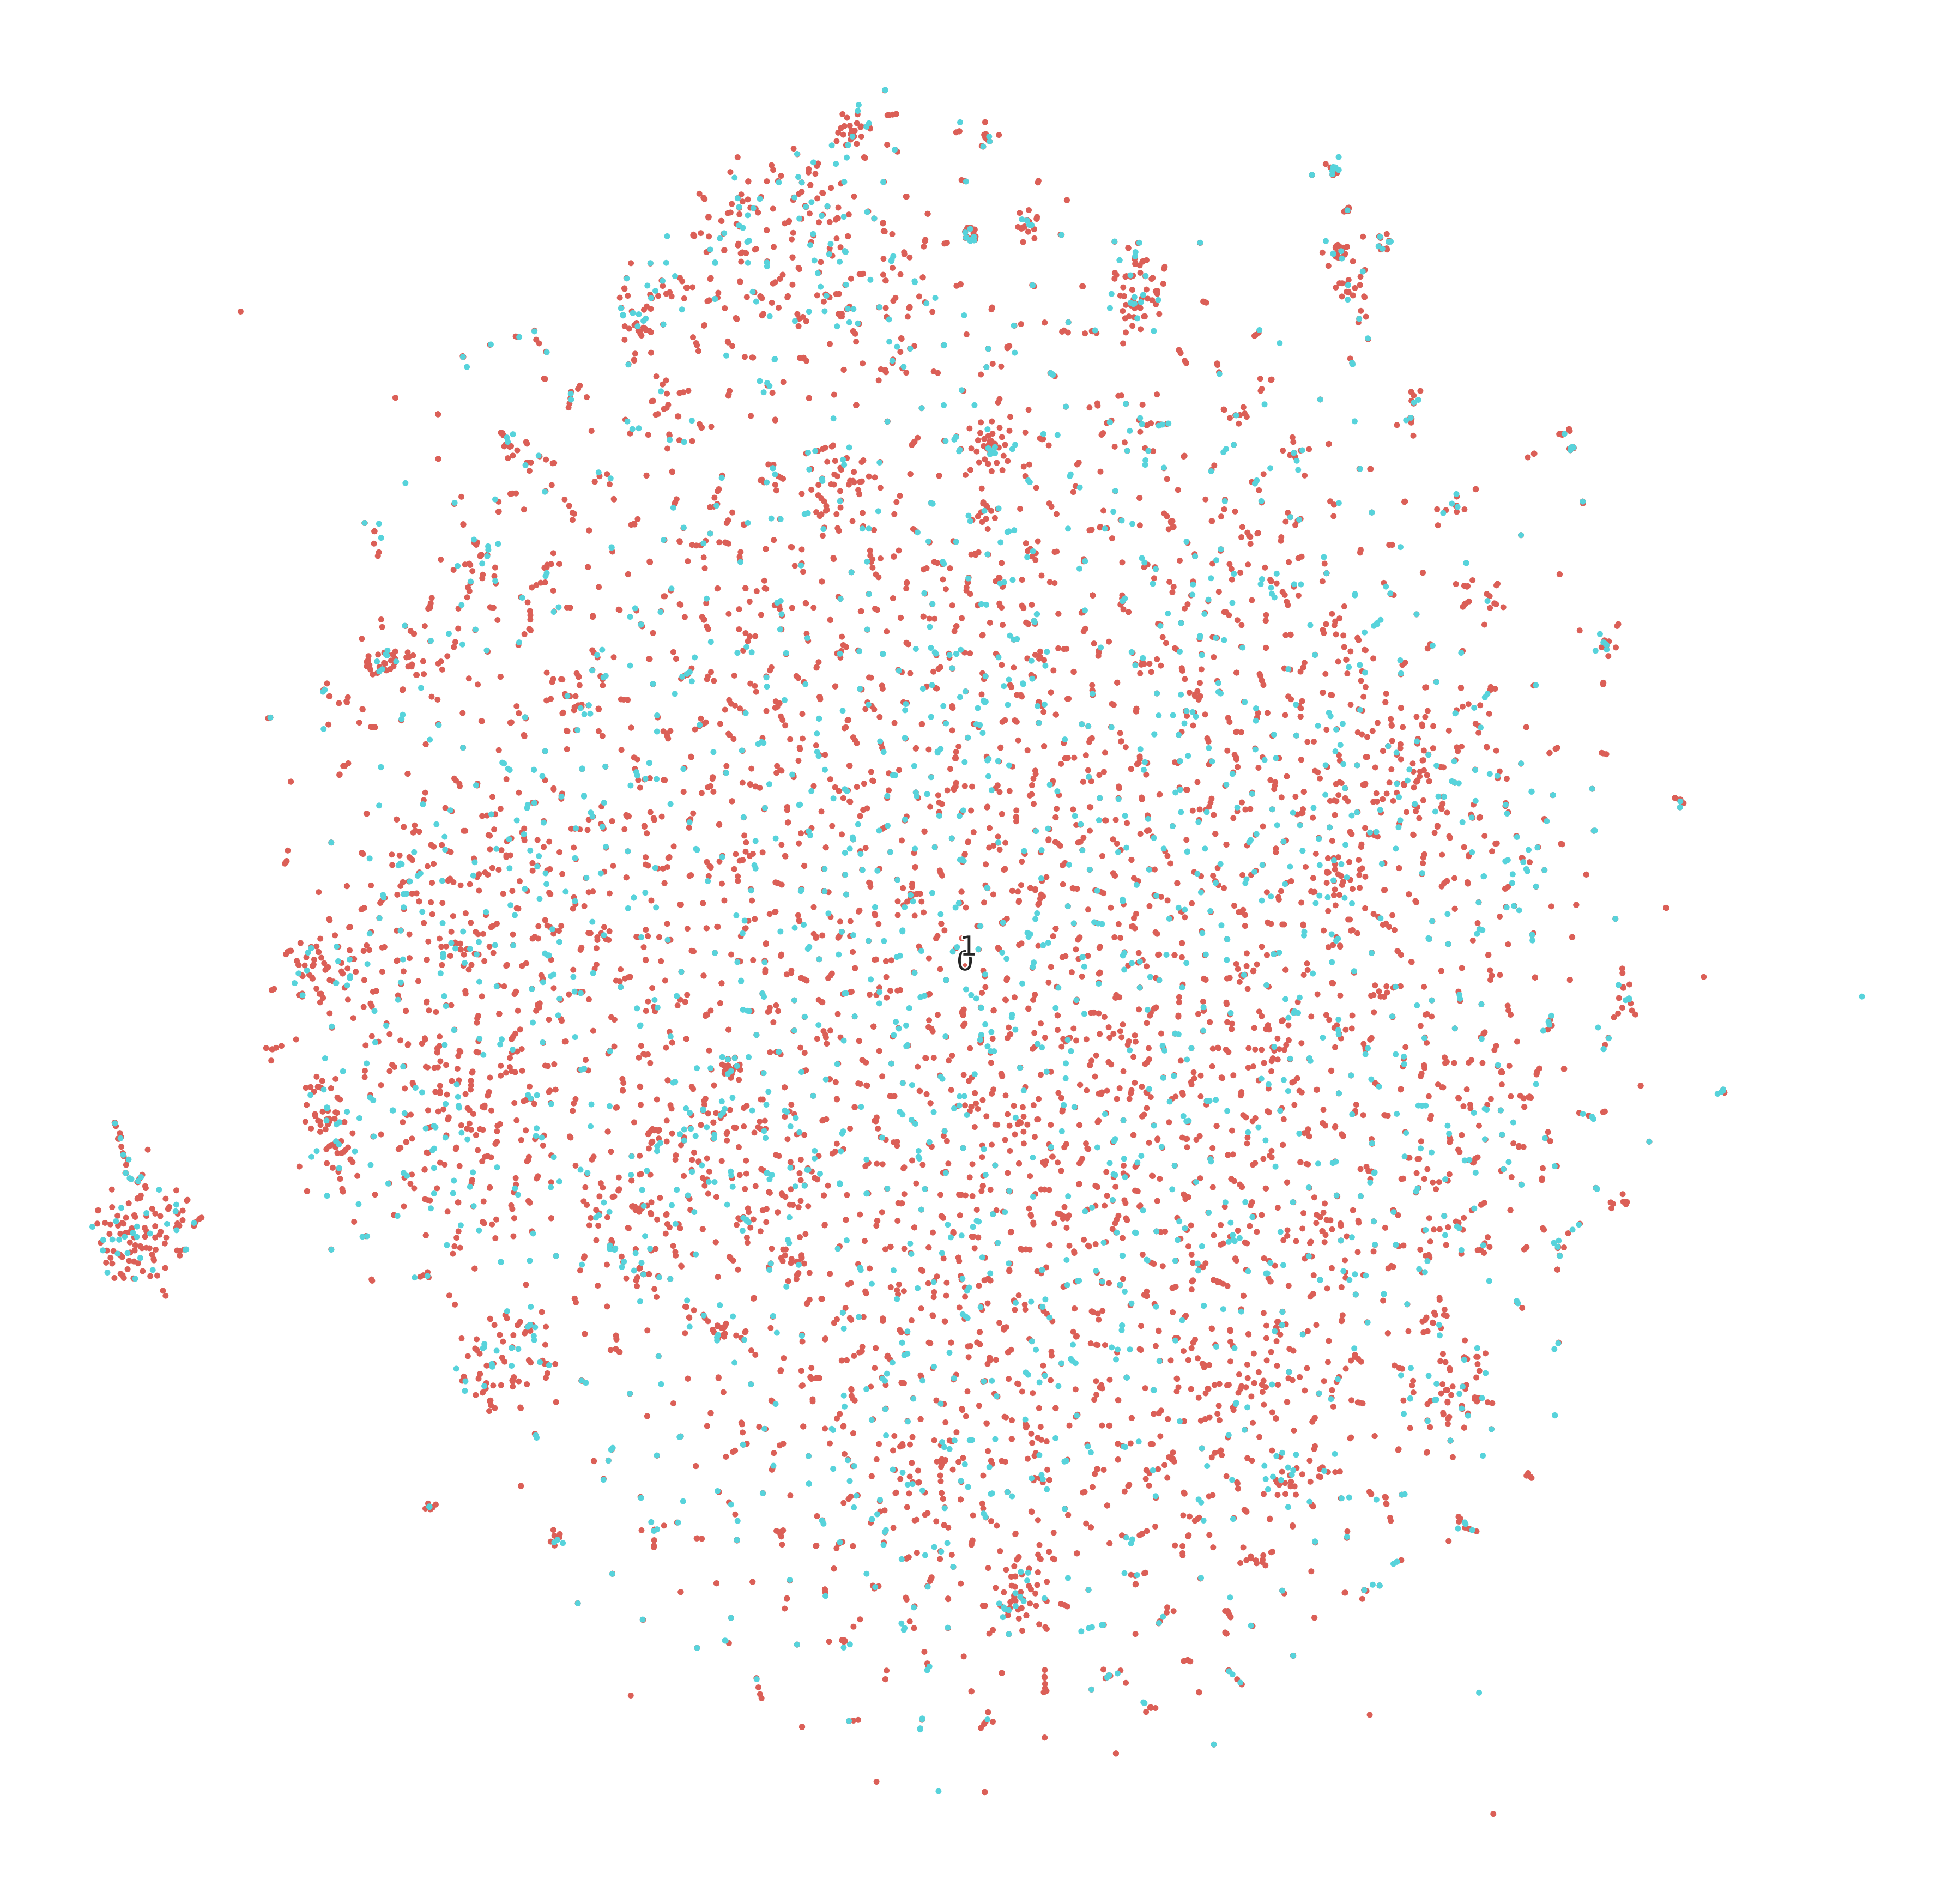

In [7]:
digits_proj = TSNE(random_state=RS).fit_transform(X,y)
print(['Train','Validation'])
sns.palplot(np.array(sns.color_palette("hls", 2)))
scatter(digits_proj, y)
plt.savefig('Train_vs_Val_Codalab.png', dpi=120)

**Visualisation of Training Set and Test Set**

In [11]:
tfidf = TfidfVectorizer()
df    = dataset[dataset.label!=1].reset_index(drop=True)
df['label']=df['label'].map({0:0,2:1})
X     = tfidf.fit_transform(df.tweet)
y     = df.label

['Train', 'Test']


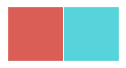

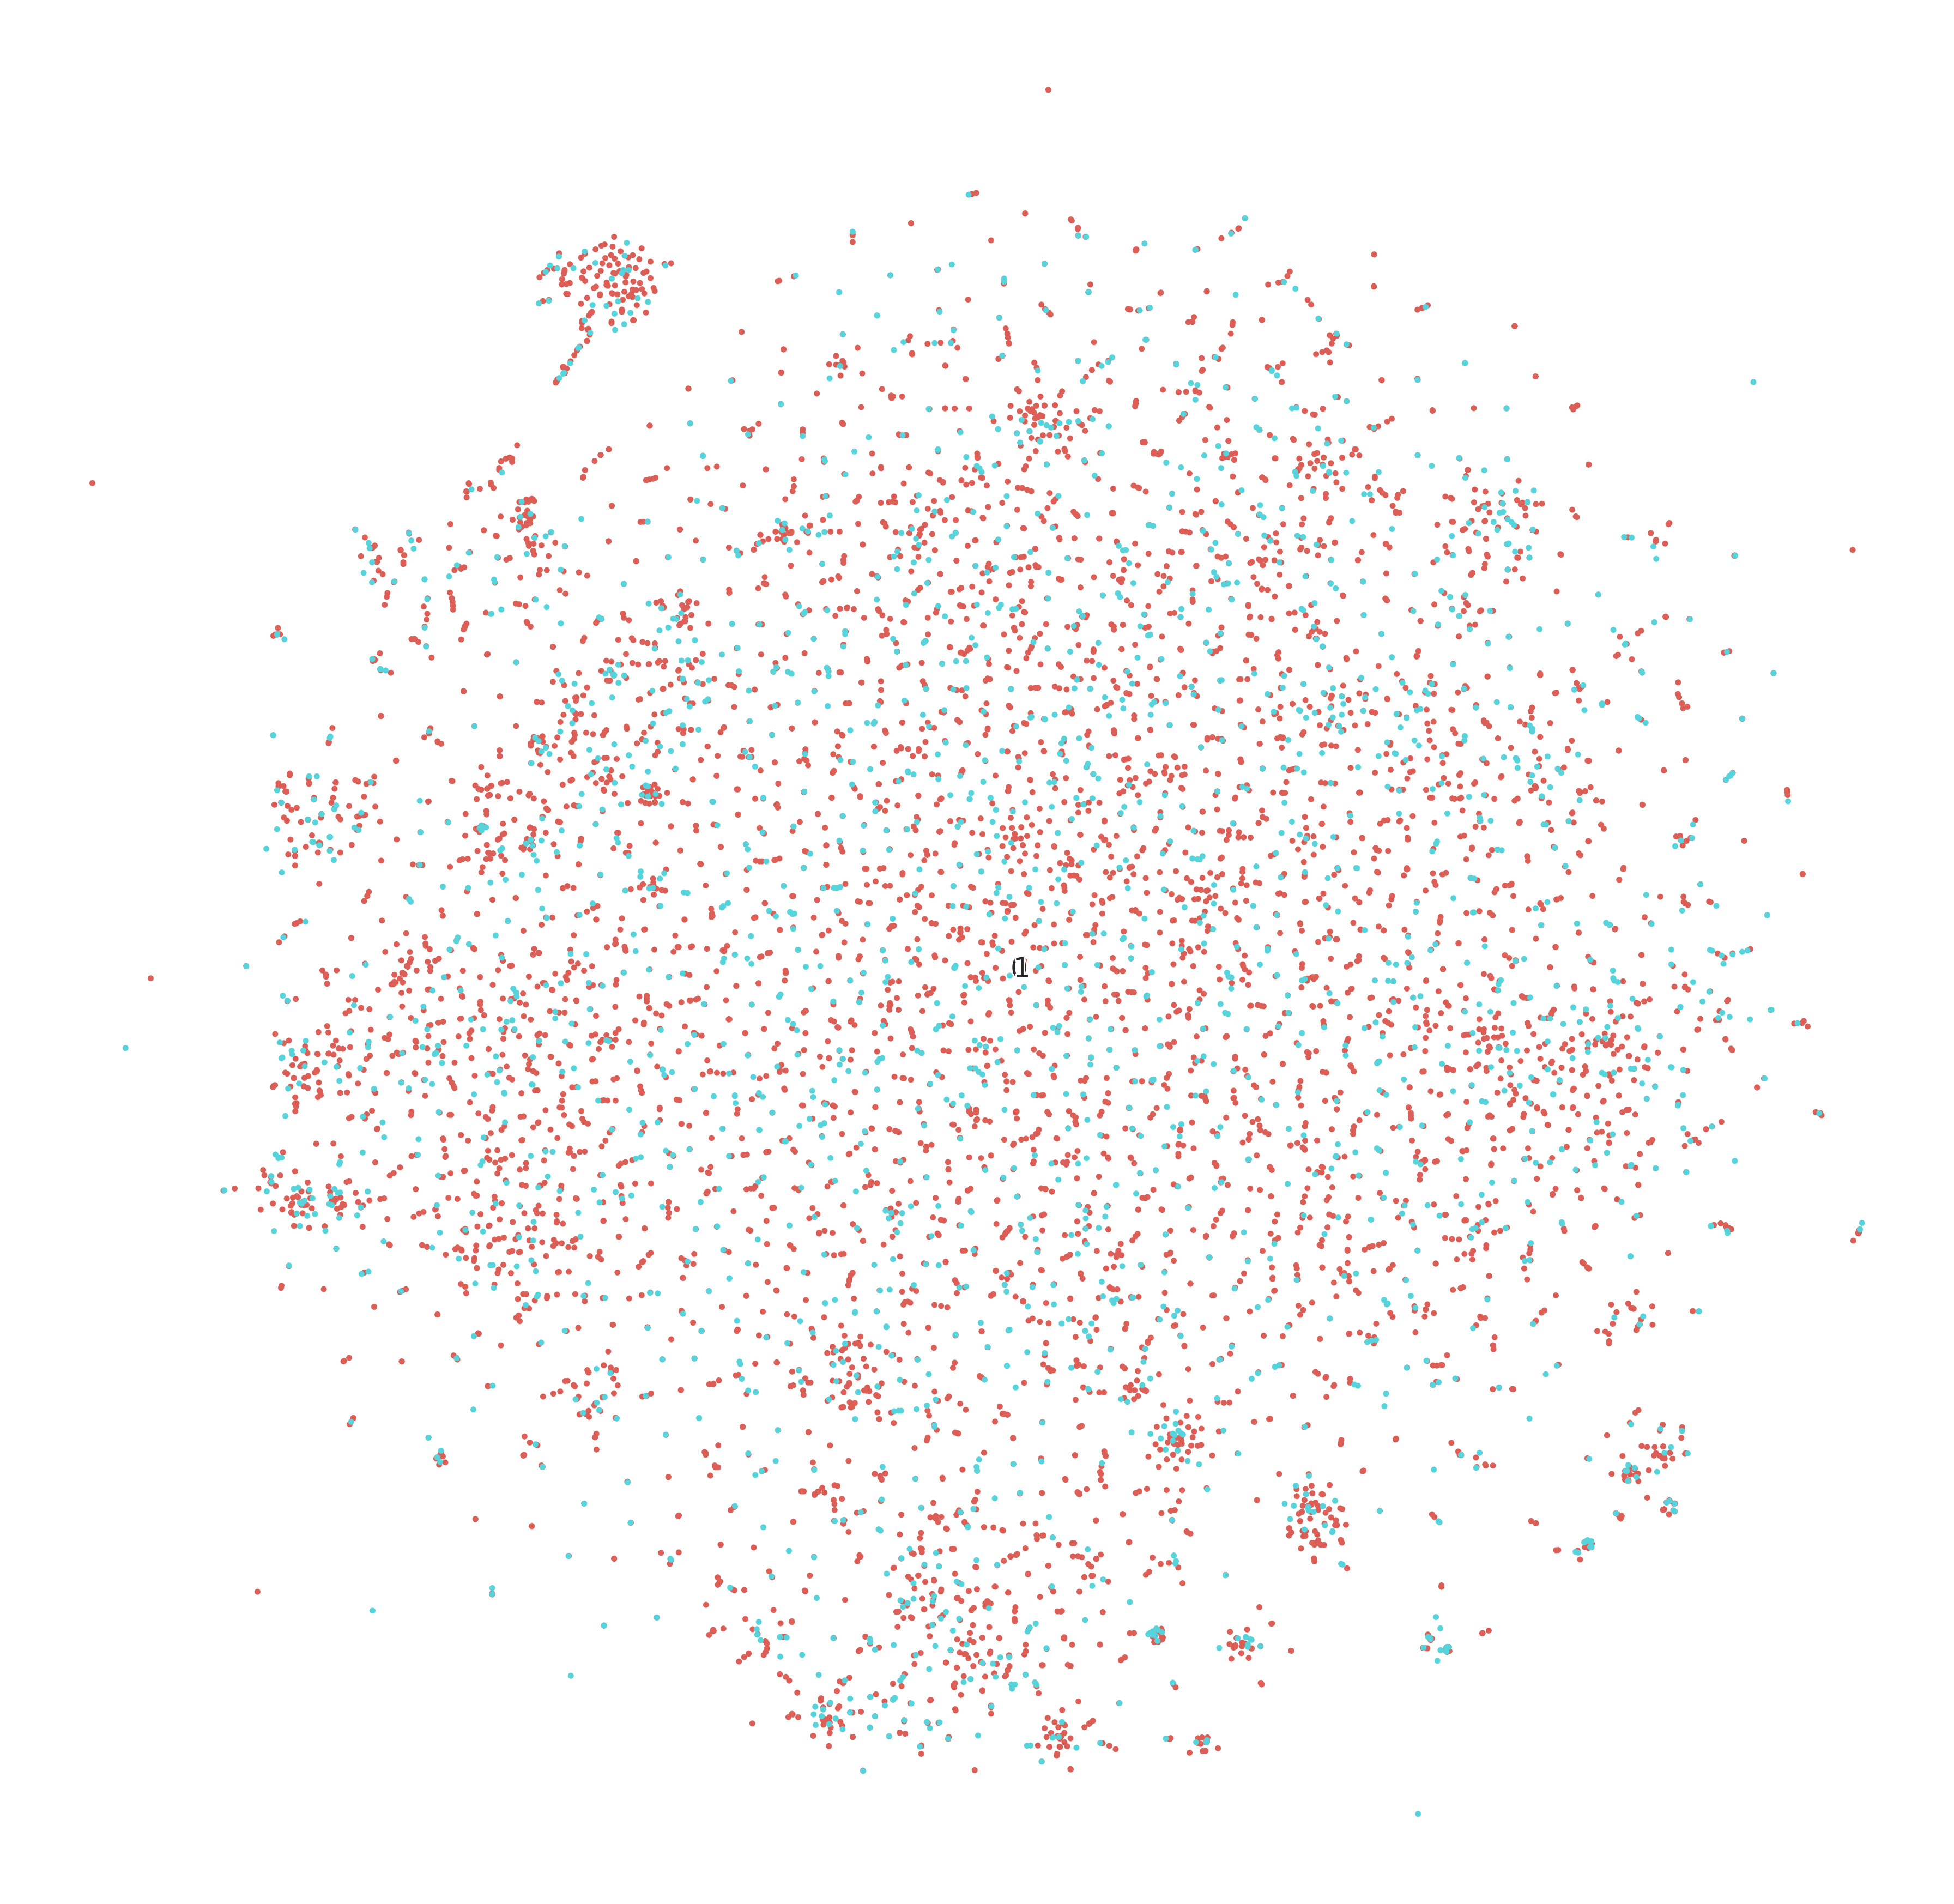

In [12]:
digits_proj = TSNE(random_state=RS).fit_transform(X,y)
print(['Train','Test'])
sns.palplot(np.array(sns.color_palette("hls", 2)))
scatter(digits_proj, y)
plt.savefig('Train_vs_Test_Codalab.png', dpi=120)

**Visualisation of Validation and Testing Set**

In [13]:
tfidf = TfidfVectorizer()
df    = dataset[dataset.label!=0].reset_index(drop=True)
df['label']=df['label'].map({1:0,2:1})
X     = tfidf.fit_transform(df.tweet)
y     = df.label

['Validation', 'Test']


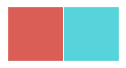

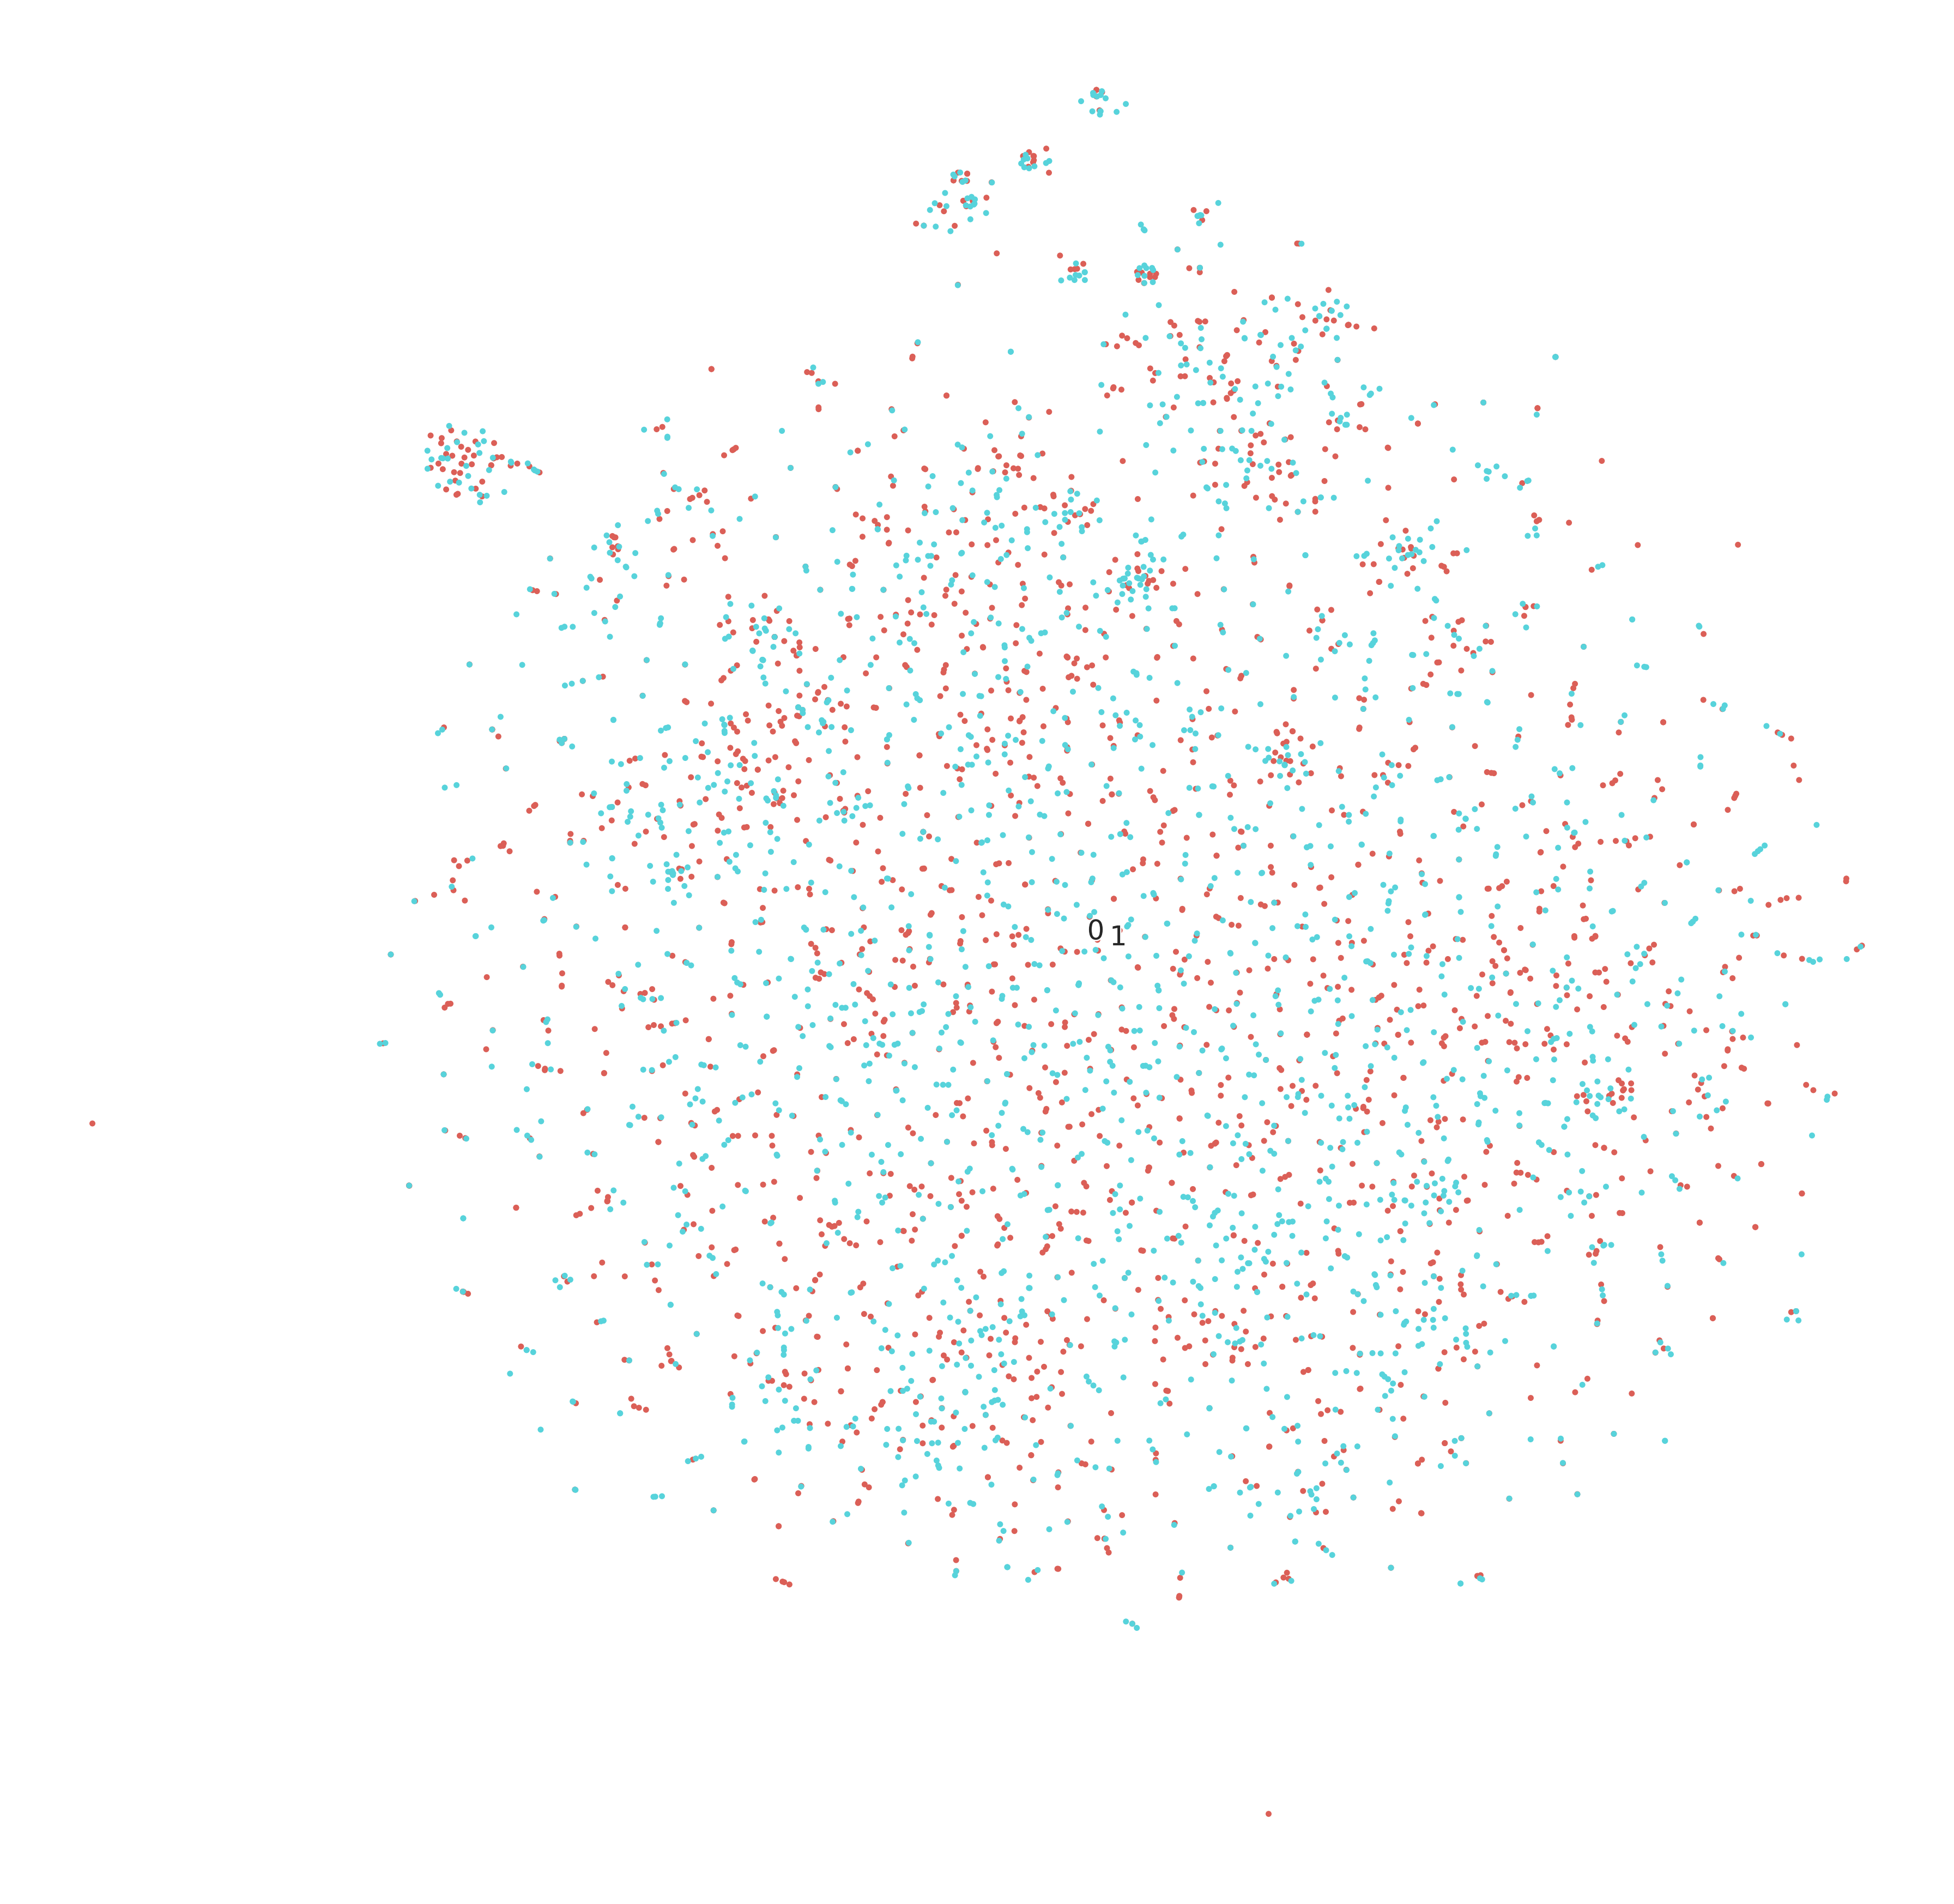

In [14]:
digits_proj = TSNE(random_state=RS).fit_transform(X,y)
print(['Validation','Test'])
sns.palplot(np.array(sns.color_palette("hls", 2)))
scatter(digits_proj, y)
plt.savefig('Val_vs_Test_Codalab.png', dpi=120)

**Visualisation of Train+Val vs Test**

In [15]:
tfidf      = TfidfVectorizer()
df         = dataset.copy()
df['label']=df['label'].map({0:0,1:0,2:1})
X          = tfidf.fit_transform(df.tweet)
y          = df.label

['Train+Validation', 'Test']


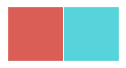

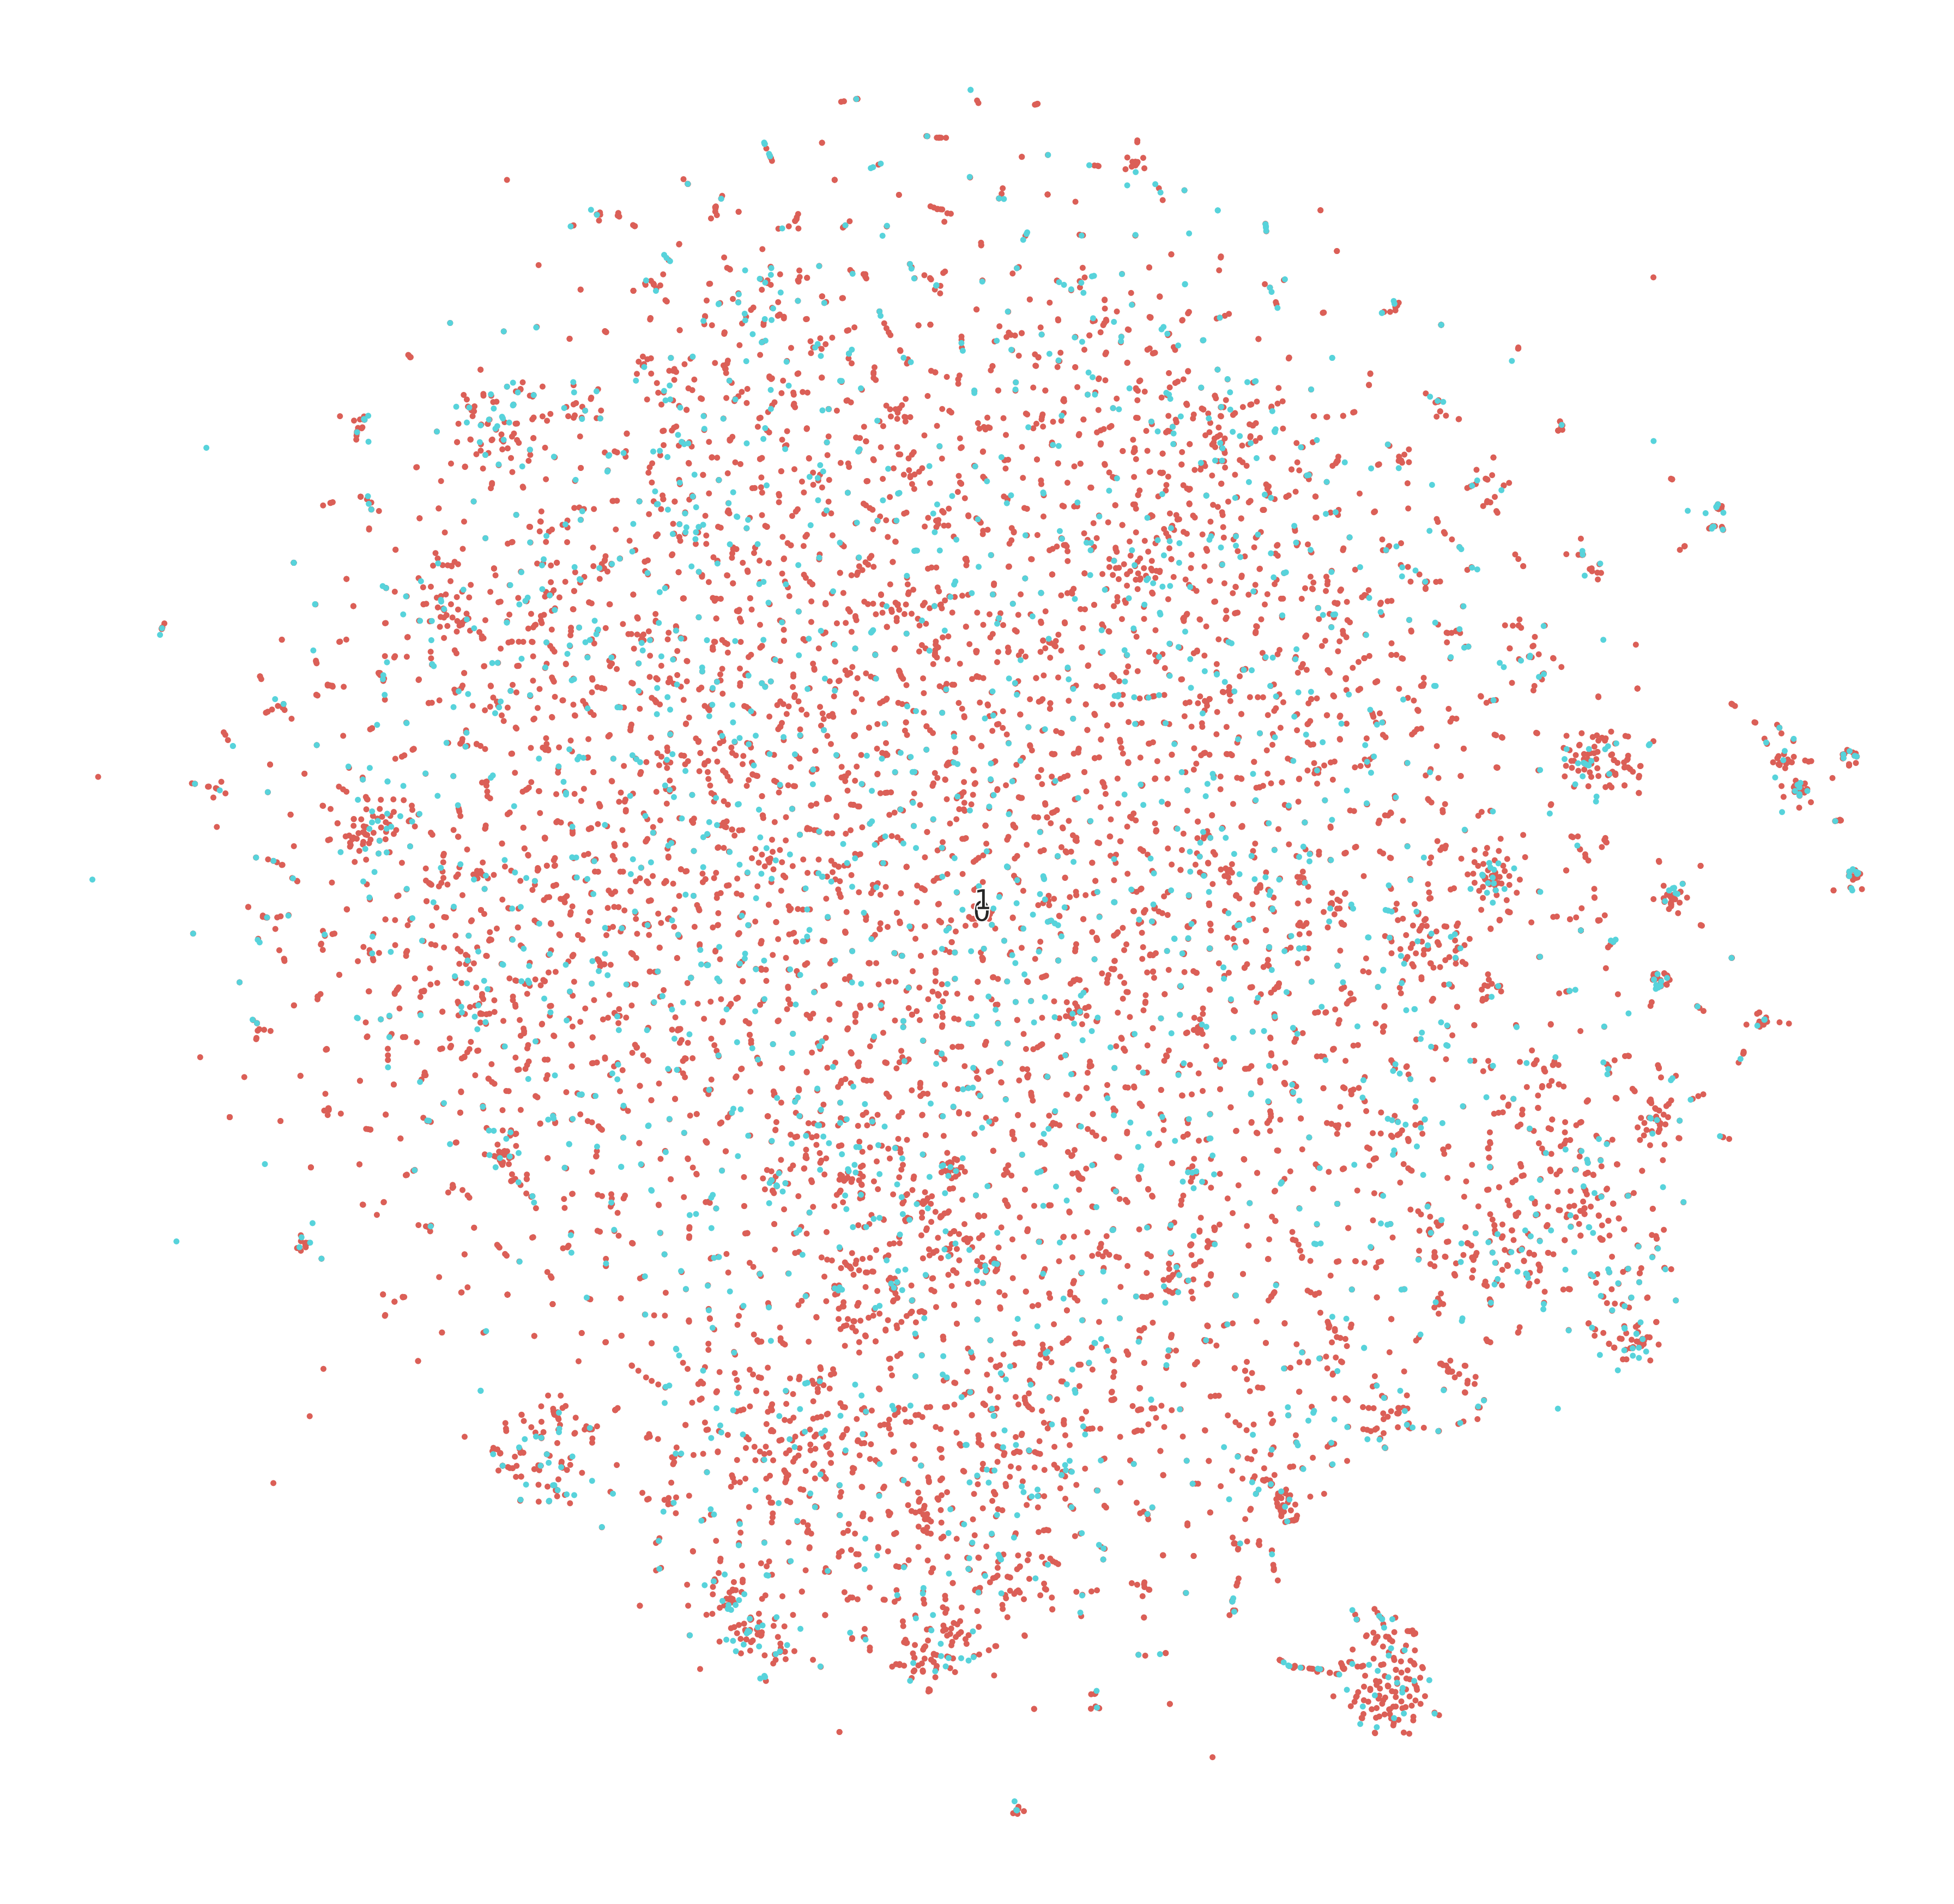

In [16]:
digits_proj = TSNE(random_state=RS).fit_transform(X,y)
print(['Train+Validation','Test'])
sns.palplot(np.array(sns.color_palette("hls", 2)))
scatter(digits_proj, y)
plt.savefig('TrainVal_vs_Test_Codalab.png', dpi=120)